In [1]:
import sys
sys.path.append('..')

from glob import glob

import torch
import random
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

from models import Surrogate1D, Surrogate2D
from dataset.ba_dataset import GISAXSDataModule


def get_rich_bar():
    return  RichProgressBar(
                theme=RichProgressBarTheme(
                    description="black",
                    progress_bar="green",
                    progress_bar_finished="green",
                    progress_bar_pulse="#6206E0",
                    batch_progress="green",
                    time="gray48",
                    processing_speed="gray48",
                    metrics="gray48",
                )
            )

In [2]:
mode = '2d'
batch_size = 16
lr = 5e-4
train_frac = 0.8

n_layers = 3
path = '/bigdata/hplsim/aipp/Maksim/BA_simulation/layer_{}/'.format(n_layers)
in_shape = (1200,120)
out_shape = (128,16)
to_preload = True

to_augment = 0
sigma = 0.01
drop_y = 0.05
sp_prob = 0.01
drop_prob = 0.0

In [3]:
model = Surrogate2D(n_params=n_layers*6, out_dim=out_shape, loss_name='l2', lr=lr, drop_prob=drop_prob)

In [4]:
indices = range(0,100)
data_module = GISAXSDataModule(mode, batch_size,
                               path=path, indices=indices, to_preload=to_preload, to_augment=to_augment,
                               in_shape=in_shape, out_shape=out_shape,
                               sigma=sigma, drop_y=drop_y, sp_prob=sp_prob, verbose=True)

data_module.setup()

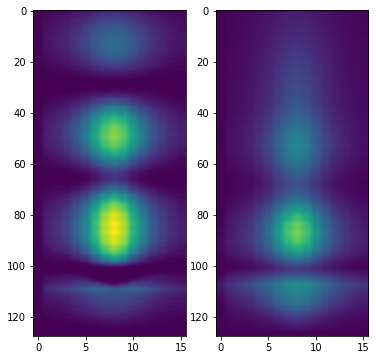

In [29]:
model = model.load_from_checkpoint(glob("../csv_logs/2d_surrogate/version_0/checkpoints/*")[0])
device = 'cpu'#"cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device);
x,y = next(iter(data_module.train_dataloader()))
x_hat = model(y.to(device)).cpu().detach().numpy()

plt.figure(figsize=[6,6])

i = random.randint(0,10)
plt.subplot(1,2,1)
plt.imshow(x[i], aspect = 'auto', vmin = 0, vmax = 1)
plt.subplot(1,2,2)
plt.imshow(x_hat[i], aspect = 'auto', vmin = 0, vmax = 1)

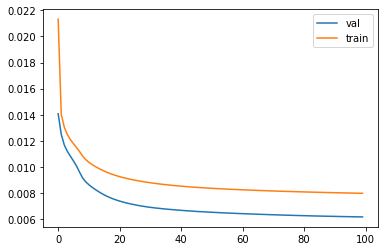

In [30]:
with open('../csv_logs/2d_surrogate/version_0/metrics.csv') as file:
    lines = file.readlines()
    stats_val = [float(line.split(',')[0]) for line in lines[1::2]]
    stats_train = [float(line.split(',')[-1]) for line in lines[2::2]]
plt.plot(stats_val, label = 'val')
plt.plot(stats_train, label = 'train')
plt.legend()
